# Прогноз уровня средней заработной платы в Рoссии

Данные из WAG_C_M.csv обновлены до января 2017 по http://sophist.hse.ru/exes/tables/WAG_M.htm

In [34]:
# библиотеки
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
import itertools

# fix cyrillic fonts
from matplotlib import rc
font = {'family': 'Verdana','weight': 'normal'}
rc('font', **font)

Populating the interactive namespace from numpy and matplotlib


In [35]:
statsmodels_ver = str.split(statsmodels.__version__, '.') 
if int(statsmodels_ver[1]) < 8:
    raise RuntimeError('Некорректная версия statsmodels, требуется ^0.8.0')

In [36]:
# из примера на лекции
def invboxcox(y, nlmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [37]:
salaries = pd.read_csv('WAG_C_M.csv',';', 
                       index_col=['month'], 
                       parse_dates=['month'],
                       header=None,
                       skiprows=1,
                       names=['month', 'salary'],
                       dayfirst=True)
salaries.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 289 entries, 1993-01-01 to 2017-01-01
Data columns (total 1 columns):
salary    289 non-null float64
dtypes: float64(1)
memory usage: 4.5 KB


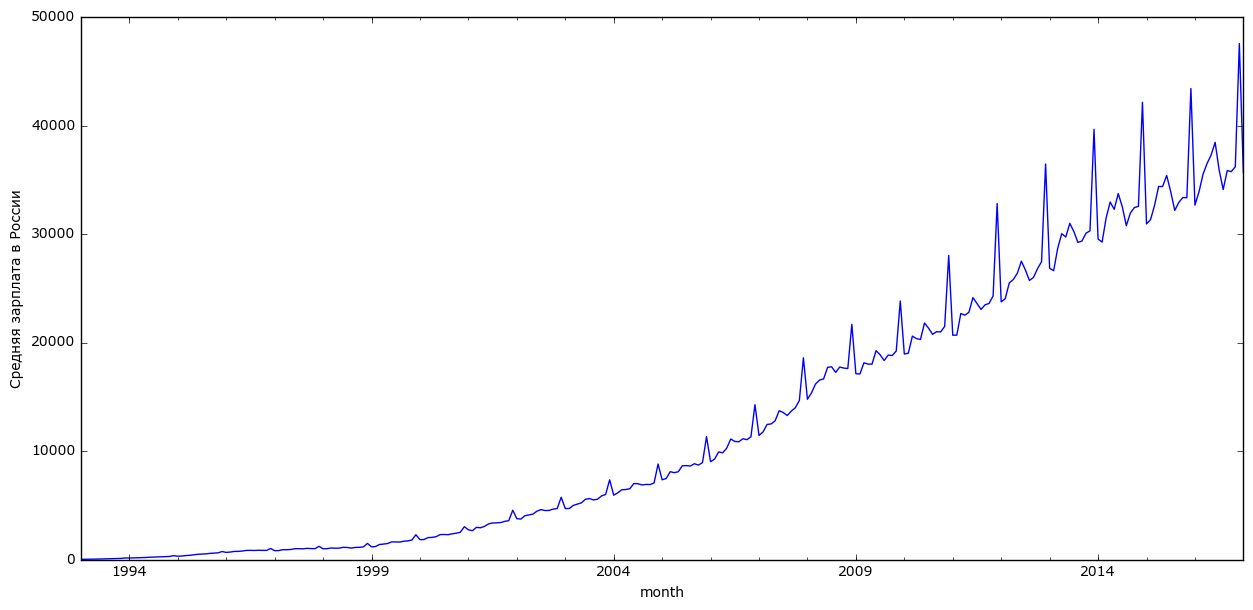

In [38]:
plt.figure(figsize(15,7))
salaries.salary.plot()
plt.ylabel('Средняя зарплата в России')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.997633


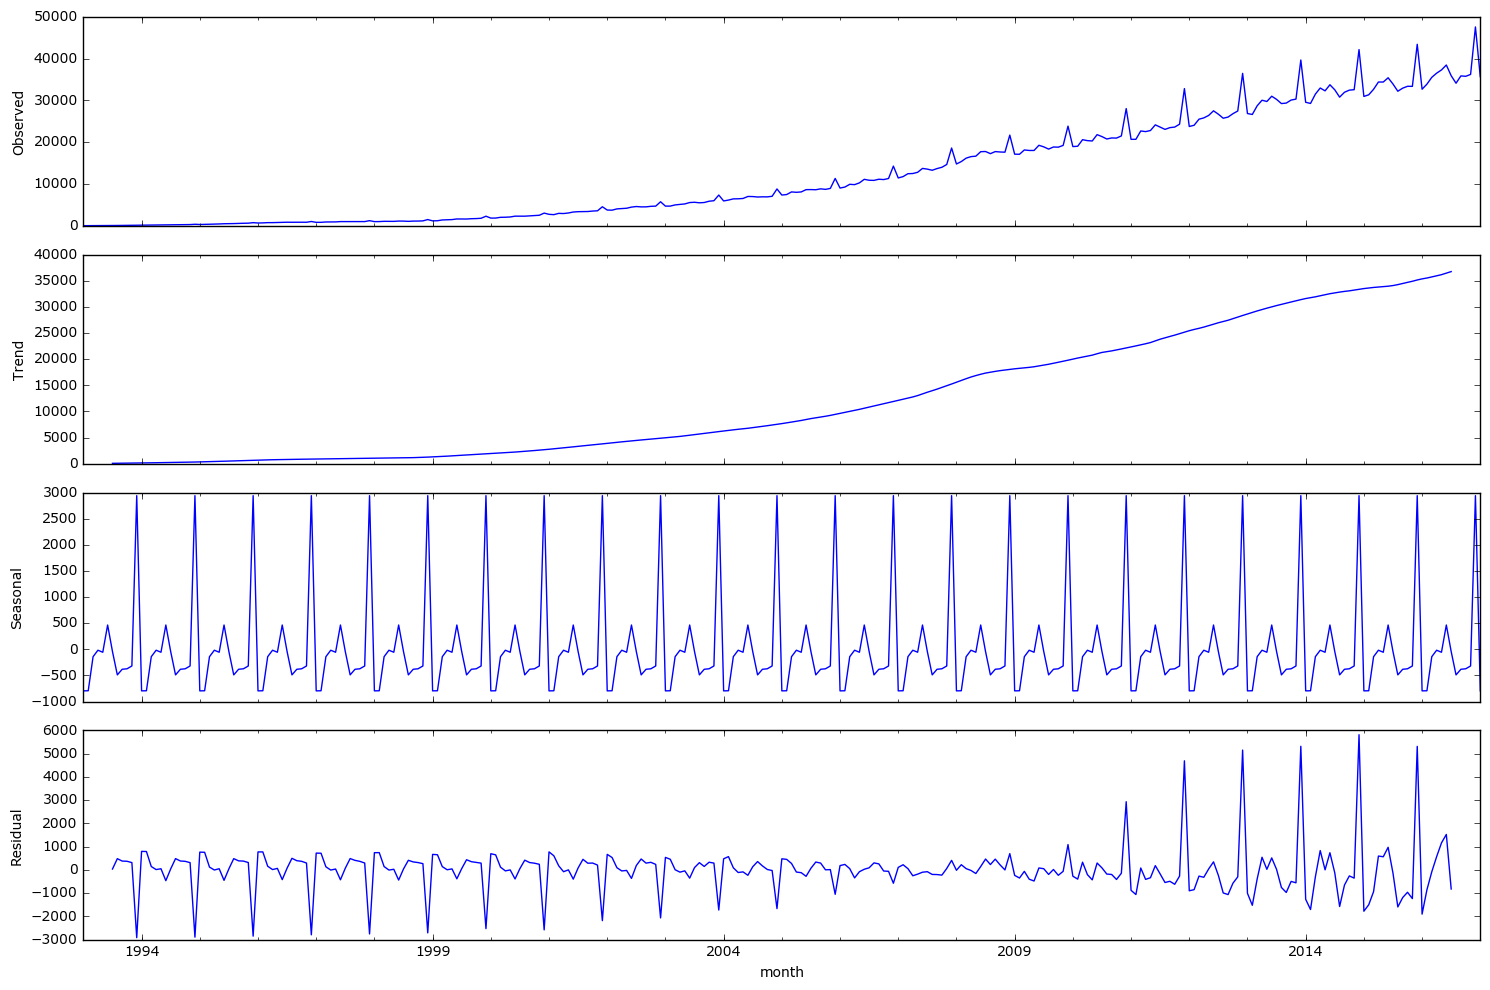

In [41]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salaries.salary).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salaries.salary)[1])

Видим что остатки содержат большое количество сезонной информации и простым сложением тренда и стационарной сезонности их не получить. Копаем дальше.

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.266568
Критерий Дики-Фуллера: p=0.800010


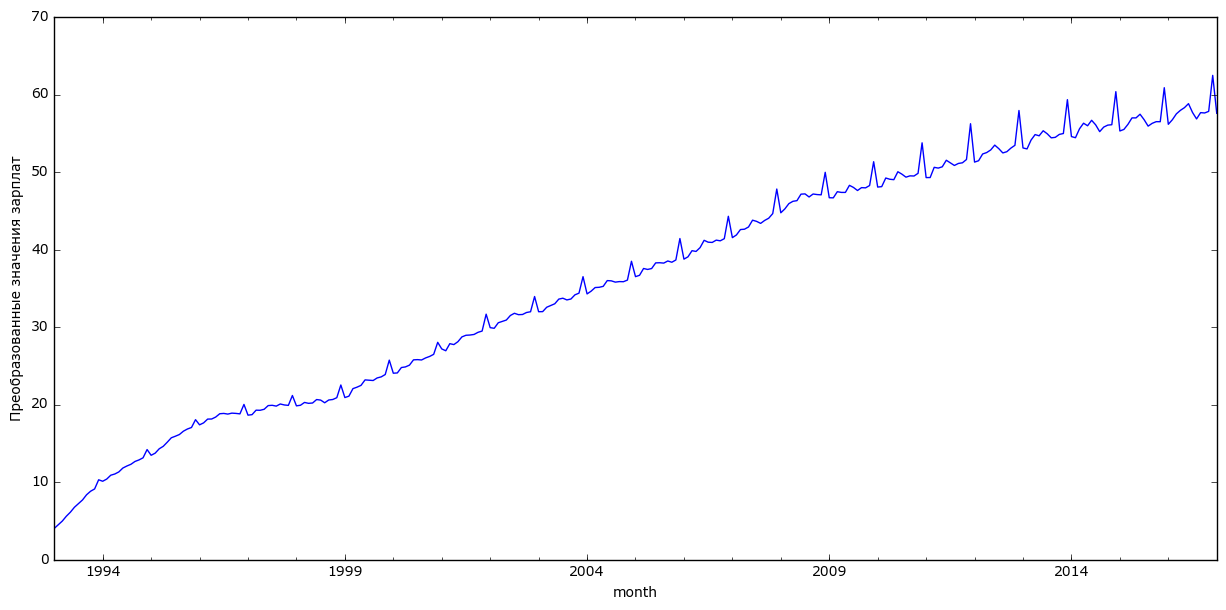

In [44]:
salaries['salary_box'], lmbda = stats.boxcox(salaries.salary)
plt.figure(figsize(15,7))
salaries.salary_box.plot()
plt.ylabel(u'Преобразованные значения зарплат')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salaries.salary_box)[1])

### Приведение с стационарности

Критерий Дики-Фуллера отвергает гипотезу нестационарности. Преобразование Бокса-Кокса не слишком его уменьшило.
Попробуем убрать влияние тренда сезонным дифференцированием; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.007931


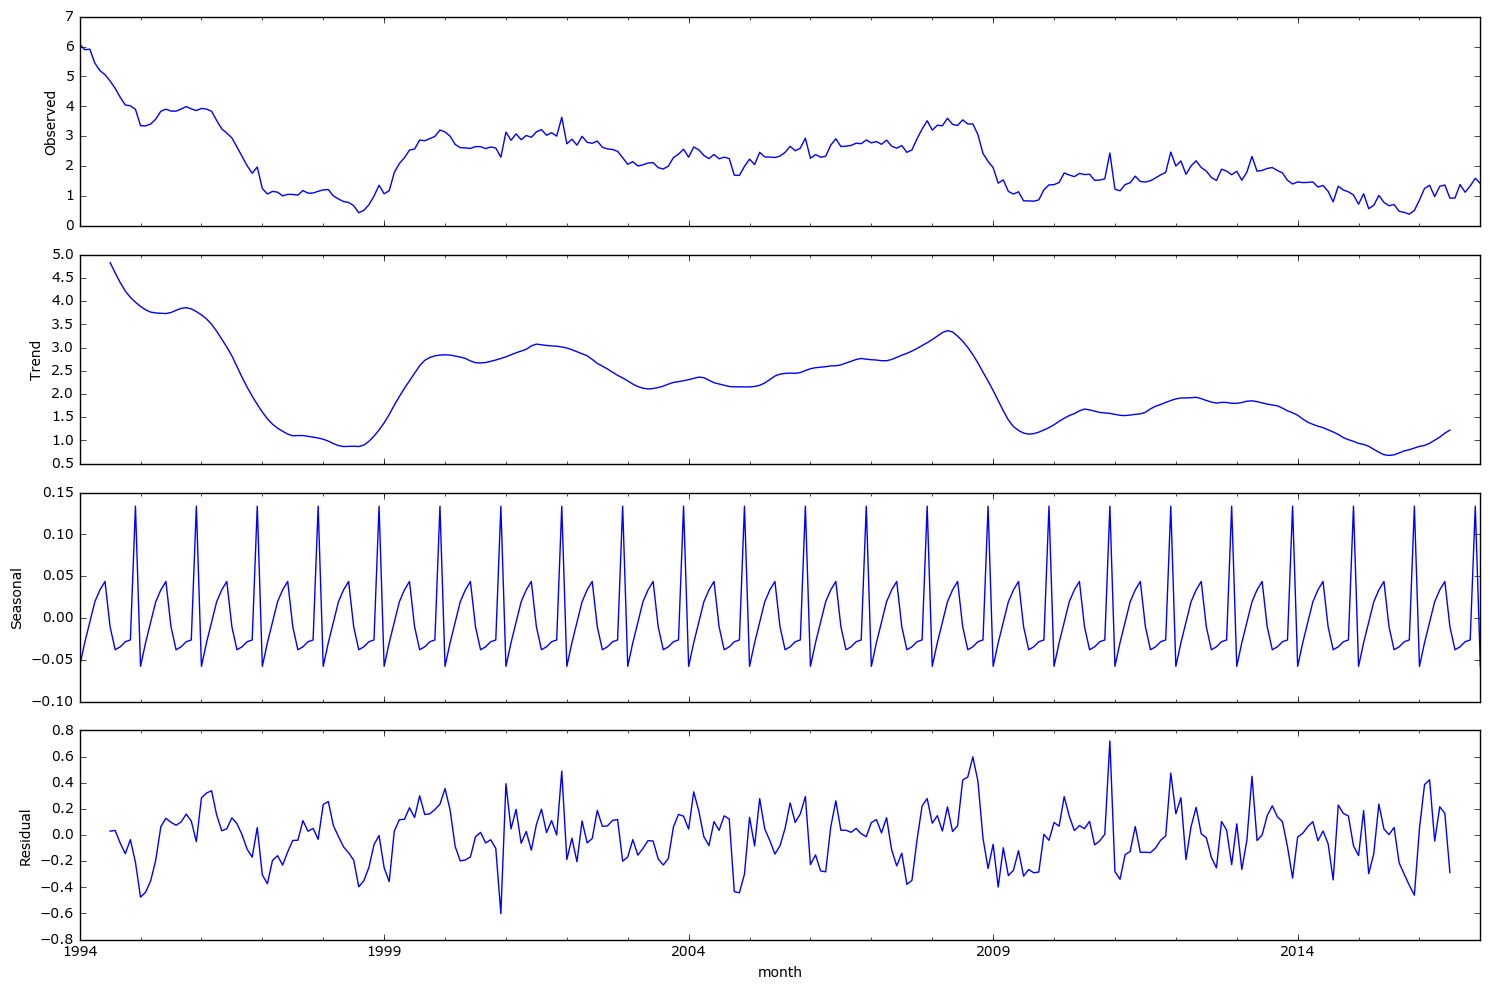

In [52]:
salaries['salary_box_diff_12'] = salaries.salary_box - salaries.salary_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salaries.salary_box_diff_12[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salaries.salary_box_diff_12[12:])[1])

После однократного сезонного дифференцирования вспыхнул свет в конце тоннеля. Критерий Дики-Фуллера в 0.008 говорит, что мы на верном пути и дальнейшего дифференцирования не требуется. 
На всякий случай попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


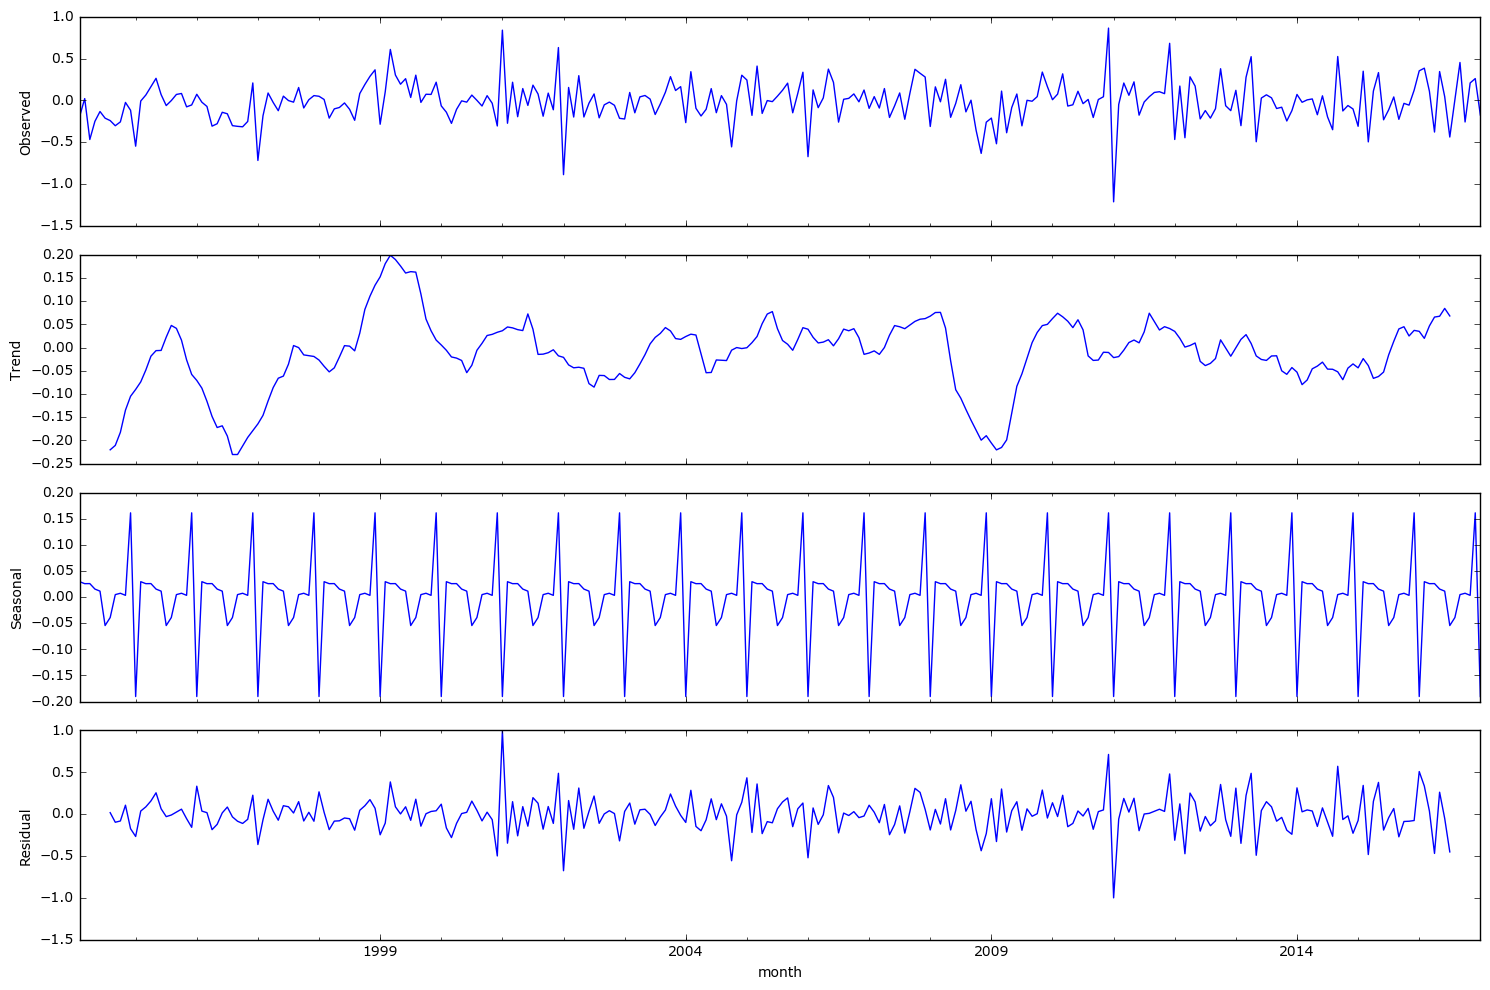

In [53]:
salaries['salary_box_diff_12_1'] = salaries.salary_box_diff_12 - salaries.salary_box_diff_12.shift(1)
p = plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salaries.salary_box_diff_12_1[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salaries.salary_box_diff_12_1[13:])[1])

Критерий Дики-Фуллера только увеличился (0.01 > 0.008). Принимаем D=1, d=0

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

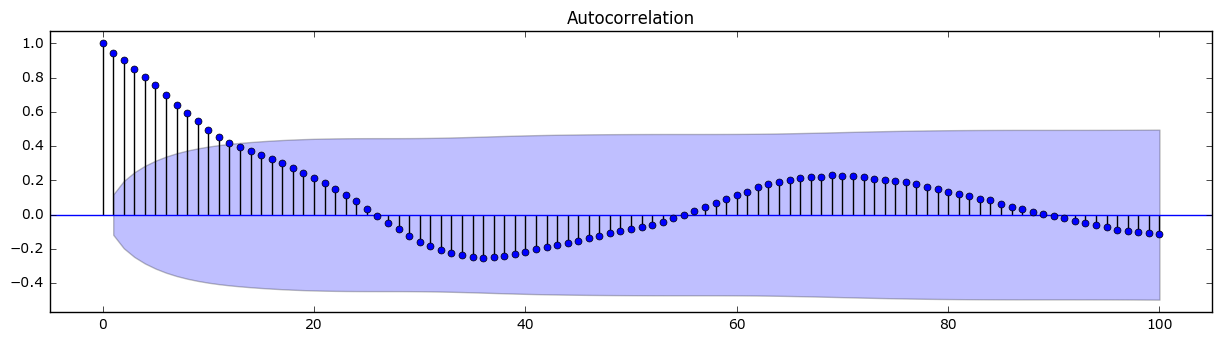

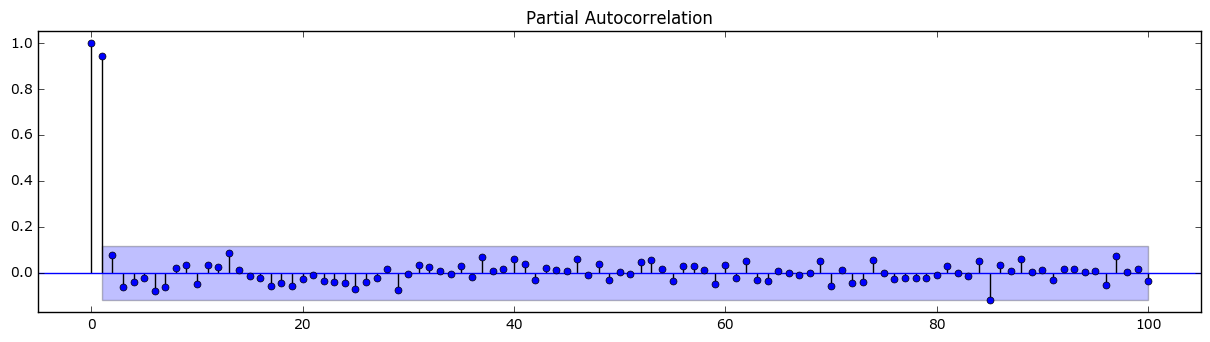

In [55]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salaries.salary_box_diff_12[12:].values.squeeze(), lags=100, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salaries.salary_box_diff_12[12:].values.squeeze(), lags=100, ax=ax)
pylab.show()

Выбираем начальные приближения: 
Q = 0 (нет значимых повторений сезонности в ACF), 
q = 11 (12 - нельзя, накроется сезонностью), 
P = 1 (можно и 2, но уже и так параметров много), 
p = 2 (второй пик на PACF)

In [59]:
# приближения для перебора
ps = range(0, 3)
d = 0
qs = range(6, 12)

Ps = range(0, 2)
D = 1
Qs = [0] # без вариантов, 0 очень хорошо подтверждается графиком 

In [60]:
parameters = itertools.product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [63]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    # try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salaries.salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    # выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters: ', param)
        continue
    except LinAlgError:
        print('wrong parameters (singular matris in solving): ', param)
        continue
    
    aic = model.aic
    
    # сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters:  (0, 6, 0, 0)
wrong parameters:  (0, 6, 1, 0)
wrong parameters:  (0, 7, 0, 0)
wrong parameters:  (0, 7, 1, 0)
wrong parameters:  (0, 8, 0, 0)
wrong parameters:  (0, 8, 1, 0)
wrong parameters:  (0, 9, 0, 0)
wrong parameters:  (0, 9, 1, 0)
wrong parameters:  (0, 10, 0, 0)
wrong parameters:  (0, 10, 1, 0)
wrong parameters:  (0, 11, 0, 0)
wrong parameters:  (0, 11, 1, 0)
wrong parameters (singular matris in solving):  (2, 10, 0, 0)
wrong parameters (singular matris in solving):  (2, 10, 1, 0)
wrong parameters (singular matris in solving):  (2, 11, 0, 0)
wrong parameters (singular matris in solving):  (2, 11, 1, 0)
Wall time: 1min 1s


In [64]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters        aic
6    (1, 9, 0, 0)  11.444433
7    (1, 9, 1, 0)  12.078520
8   (1, 10, 0, 0)  12.716912
18   (2, 9, 0, 0)  13.095823
12   (2, 6, 0, 0)  14.166989


Лучшая модель:

In [65]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         salary_box   No. Observations:                  289
Model:             SARIMAX(1, 0, 9)x(0, 1, 0, 12)   Log Likelihood                   5.278
Date:                            Sun, 26 Feb 2017   AIC                             11.444
Time:                                    17:31:52   BIC                             51.775
Sample:                                01-01-1993   HQIC                            27.605
                                     - 01-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9893      0.007    136.044      0.000       0.975       1.004
ma.L1         -0.1824      0.049   

Её остатки:

Критерий Стьюдента: p=0.774237
Критерий Дики-Фуллера: p=0.000000


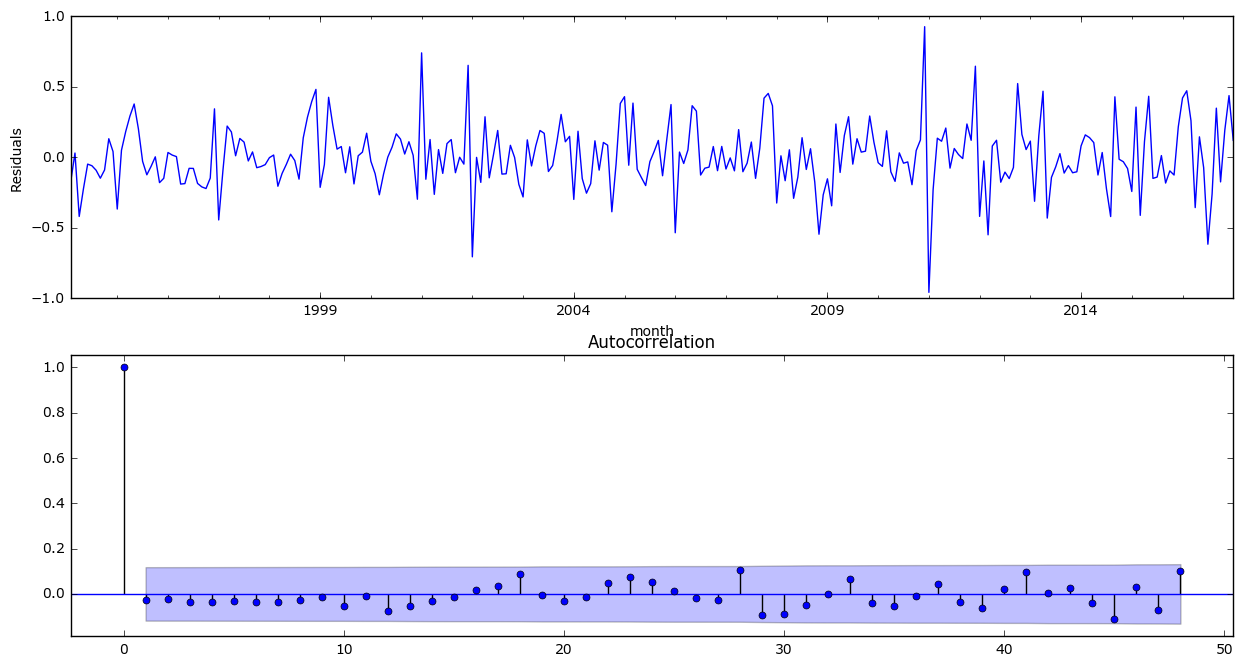

In [66]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Отлично, анлитические оценки получились намного лучше, чем в случае с австралийским вином.
Остатки несмещены - подтверждается критерием Стьюдента,  стационарны - подтверждается критерием Дики-Фуллера и визуально, и неавтокоррелированы - подтверждается критерием Льюнга-Бокса и коррелограммой.

Проверим, насколько хорошо модель описывает данные:

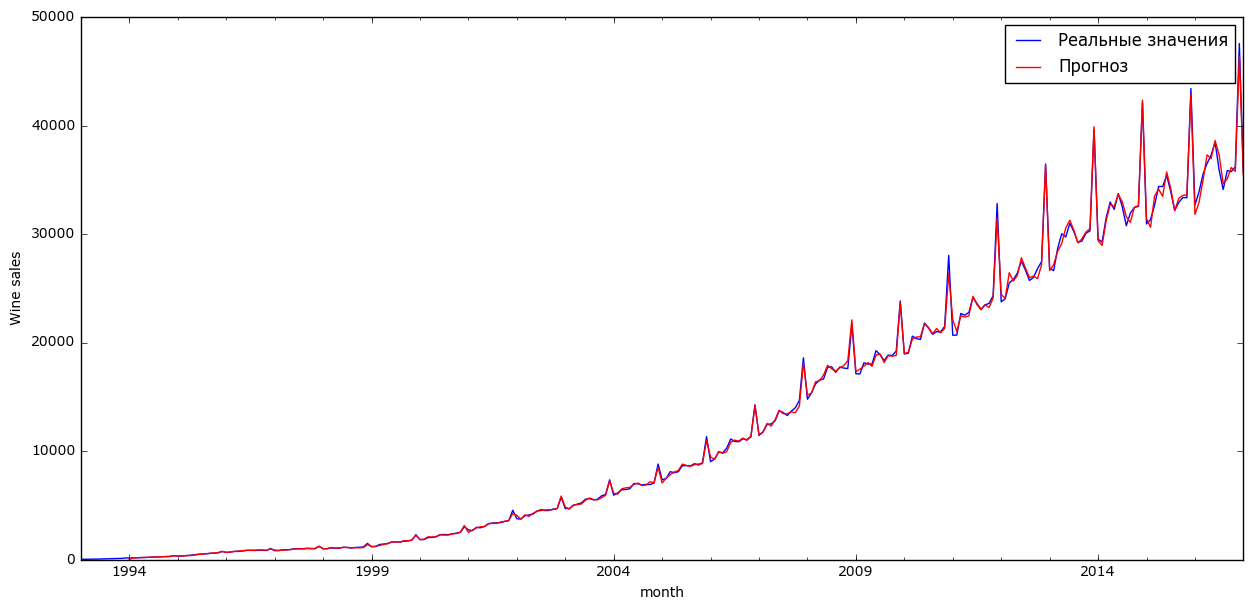

In [73]:
salaries['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))

salaries.salary.plot(label = 'Реальные значения') 
salaries.model[12:].plot(color='r', label = 'Прогноз')

plt.ylabel('Wine sales')
plt.legend()
pylab.show()

We are the masters of statistics!!!

### Прогноз

In [95]:
salaries_predict = salaries[['salary']]
date_list = [datetime.datetime.strptime("2017-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= salaries_predict.columns)
salaries_predict = pd.concat([salaries_predict, future])
predict_start = salaries.shape[0]

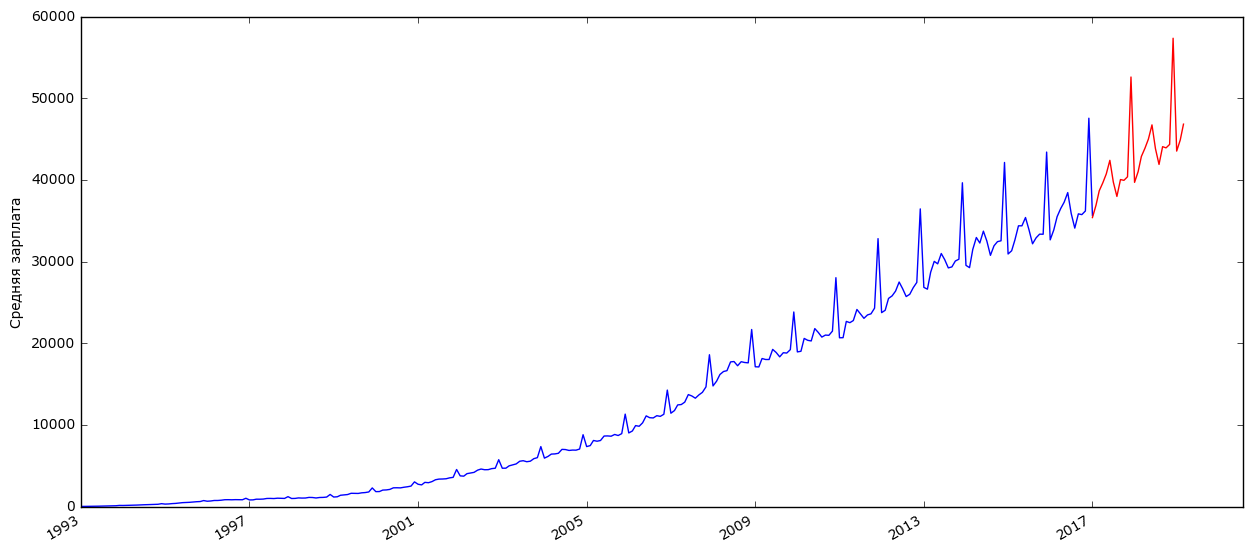

In [97]:
salaries_predict['forecast'] = invboxcox(best_model.predict(start=predict_start-1, end=predict_start + 25), lmbda)

plt.figure(figsize(15,7))
salaries_predict.salary.plot()
salaries_predict.forecast.plot(color='r')
plt.ylabel('Средняя зарплата')
#pylab.show()

### Вывод
С уверенностью в 80% (критерий Стьюдента) мы можем сказать, что средняя зарплата в России будет расти и характер ее сезонных колебаний не изменится.